In [1]:
import scipy
import math
import cv2
import matplotlib
%matplotlib inline
import pylab as plt
import numpy as np
from PIL import Image
import time
#import matplotlib.pyplot as plt
import keras
import keras.models
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
import digit_detector.region_proposal as rp
import digit_detector.show as show
import digit_detector.detect as detector
import digit_detector.file_io as file_io
import digit_detector.preprocess as preproc
import digit_detector.classify as cls
from openpose.config_reader import config_reader
import openpose.util as util
import color.utils as utils

Using TensorFlow backend.


Load a sample image

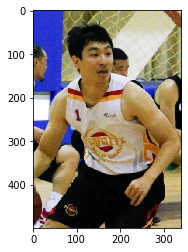

In [2]:
test_image = 'C:/Users/shing/project/face_data/Test/test.JPG'

# OpenCV 讀取進來的圖片會以 B,G,R 的方式儲存三個顏色的 channel
oriImg = cv2.imread(test_image) 

# 而Matplotlib 用的 R,G,B的格式, 所以要做順序調整[2,1,0]才有辦法正確顯圖
# https://blog.gtwang.org/programming/opencv-basic-image-read-and-write-tutorial/
plt.imshow(oriImg[:,:,[2,1,0]])

Helper functions to create a model

In [3]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Create keras model and load weights

In [4]:
weights_path = "model/keras/model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

Instructions for updating:
Colocations handled automatically by placer.


Load configuration

In [5]:
param, model_params = config_reader()

# multiplier是用四種不同尺度的影象去作為輸入，有利於學習關節的空間關係
# !!! 為什麼是這四種尺寸?
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

Show sample heatmaps for right elbow and paf for right wrist and right elbow

In [12]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    #print("Input shape: " + str(input_img.shape))  
    output_blobs = model.predict(input_img)
    #print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)


(1, 184, 128, 3)
[array([[[[ 6.95058145e-04,  1.83992821e-03, -4.43205645e-05, ...,
           1.65435980e-04,  2.59901193e-04,  1.36061863e-04],
         [ 4.75990702e-04,  9.27285291e-04, -7.36568909e-05, ...,
           8.19657580e-05,  1.13288756e-04,  7.27072766e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         ...,
         [ 1.39645603e-03,  4.63039475e-03,  4.50781808e-05, ...,
           1.05694613e-04,  2.05081567e-04,  8.04120282e-05],
         [ 1.41655176e-03,  4.71124146e-03,  4.76704299e-05, ...,
           1.06212668e-04,  2.07085599e-04,  8.05802410e-05],
         [ 9.19844315e-04,  2.78627547e-03, -1.45800150e-05, ...,
           9.25876084e-05,  1.62811717e-04,  7.60474868e-05]],

        [[ 6.70017384e-04,  1.70787098e-03, -4.86284953e-05, ...,
           8.69676078e-05,  1.32637942e-04,  7.43313794e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
    

(1, 368, 256, 3)
[array([[[[ 3.65493412e-04,  4.82745323e-04, -8.79104555e-05, ...,
           7.91172279e-05,  1.02269485e-04,  7.17823641e-05],
         [ 2.91132630e-04,  1.83585667e-04, -9.75025978e-05, ...,
           7.72002677e-05,  9.48539018e-05,  7.11599278e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         ...,
         [ 3.12672637e-04,  2.22190283e-04, -1.33990965e-04, ...,
           3.07580427e-04,  1.99964008e-04,  5.27896264e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05]],

        [[ 3.01151915e-04,  2.23894167e-04, -9.62101622e-05, ...,
           7.74585569e-05,  9.58530727e-05,  7.12437904e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
    

[array([[[[ 4.34616930e-04,  7.60835130e-04, -7.89938931e-05, ...,
           8.08991754e-05,  1.09162786e-04,  7.23609628e-05],
         [ 4.15067043e-04,  6.82184240e-04, -8.15157255e-05, ...,
           8.03951989e-05,  1.07213185e-04,  7.21973192e-05],
         [ 3.23317945e-04,  3.13069962e-04, -9.33508636e-05, ...,
           7.80299742e-05,  9.80635668e-05,  7.14293346e-05],
         ...,
         [ 1.44244242e-03,  3.53831402e-03,  3.84074752e-04, ...,
           1.14495269e-04,  2.60614266e-04, -2.93945777e-06],
         [ 1.12346979e-03,  3.46272299e-03,  1.13944378e-04, ...,
           9.62998965e-05,  2.06460187e-04,  7.06361679e-05],
         [ 1.61401671e-03,  5.50530991e-03,  7.28565938e-05, ...,
           1.12975613e-04,  2.27526936e-04,  8.20981222e-05]],

        [[ 3.60258651e-04,  4.61685500e-04, -8.85857080e-05, ...,
           7.89822807e-05,  1.01747450e-04,  7.17385410e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198

[array([[[[ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         ...,
         [ 1.65531505e-03,  5.92050375e-03,  6.16787584e-05, ...,
           2.47922377e-04,  3.12935153e-04,  6.99662996e-05],
         [ 1.35201251e-03,  4.45159478e-03,  3.93452065e-05, ...,
           1.04548897e-04,  2.00649461e-04,  8.00400157e-05],
         [ 8.30555975e-04,  2.35373084e-03, -2.79198866e-05, ...,
           9.11061652e-05,  1.48647552e-04,  7.56751688e-05]],

        [[ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198e-05,  8.90979281e-05,  7.06767896e-05],
         [ 2.33413753e-04, -4.86221688e-05, -1.04948020e-04, ...,
           7.57123198

Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

In [7]:
# 以下是根據預測的19張關節特徵圖尋找關節點對應的位置（類似於影象分割）
from scipy.ndimage.filters import gaussian_filter

all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map_ = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map_.shape)
    map_left[1:,:] = map_[:-1,:]
    map_right = np.zeros(map_.shape)
    map_right[:-1,:] = map_[1:,:]
    map_up = np.zeros(map_.shape)
    map_up[:,1:] = map_[:,:-1]
    map_down = np.zeros(map_.shape)
    map_down[:,:-1] = map_[:,1:]
    
    # 尋找區域性極值
    peaks_binary = np.logical_and.reduce((map_>=map_left, map_>=map_right, map_>=map_up, map_>=map_down, map_ > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [8]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [9]:
# 以下是根據預測出的38張paf特徵圖來預測關節連結（肢體）  
connection_all = []
special_k = []
mid_num = 10

# 計算線性積分（對應論文part assosiation部分和Fig 6）
for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        # 連線所有檢測出的關節點（nA * nB）
        for i in range(nA):
            for j in range(nB):
                # 計算單位向量
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                # 在A[i],B[j]連線上取mid_num個取樣點
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                # 根據特徵圖取取樣點的paf向量
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                # 計算餘弦值，用來衡量相似度
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                
                # 評判連線有效的兩個標準
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        # 對所有連線進行排序
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        
        # 留下對於每個關節點得分最高的連線，連線數保證不大於nA，nB的最小值
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

function: 將檢測的關節點連線拼成人  
subset: last number in each row is the total parts number of that person  
subset: the second last number in each row is the score of the overall configuration  
candidate: 候選關節點  
connection_all: 候選limb  
ps: 這段程式碼要先看not found的狀態，生成subset  

In [10]:
#!!! 為什麼要-1?
subset = -1 * np.ones((0, 20))
# 一個id的(y,x,score,id)(關節點)
#!!!這一句我看不懂@@
candidate = np.array([item for sublist in all_peaks for item in sublist]) 

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0] # 第k個limb,左端點的候選id集合
        partBs = connection_all[k][:,1] # 第k個limb,右端點的候選id集合
        indexA, indexB = np.array(limbSeq[k]) - 1 # 關節點index

        for i in range(len(connection_all[k])): #= 1:size(temp,1) 
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):遍歷每個人(subset)
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            # 關節點在subset裡只出現一次（比如人的肩肘已經連線，此時要連線肘腕，而肘就是公共點），這構造新連線，此subset的關節數 1
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            # 對一個新連線來說，左右端點都出現，說明左右端點間還沒有連線起來。
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                #print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                
                # 如果兩個人的相同關節點沒有在各自的subset中都連成limb,那麼合併兩個subset構成一個人，關節數為兩人各自關節數相加。
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1) # 1的原因是初始值為-1
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                # 以下這段沒看出具體的作用
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            # 每出現新的關節連線組合，則說明多了一個人，於是加一個subset，且關節數 2
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [11]:
# 設定評判條件，不滿足條件則不可稱為人（刪除subset）
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

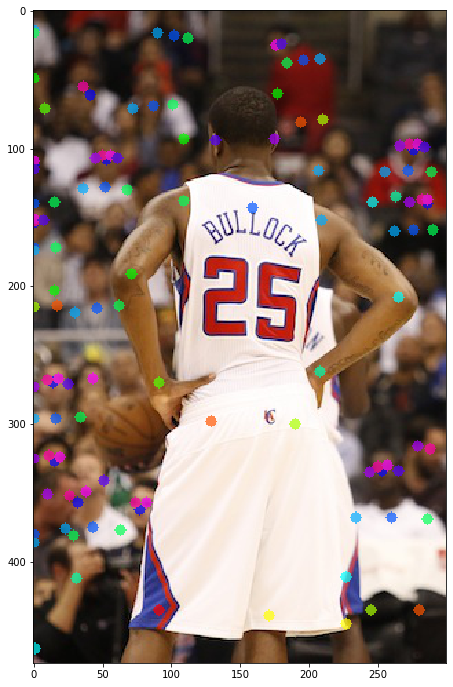

In [12]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

Link body parts

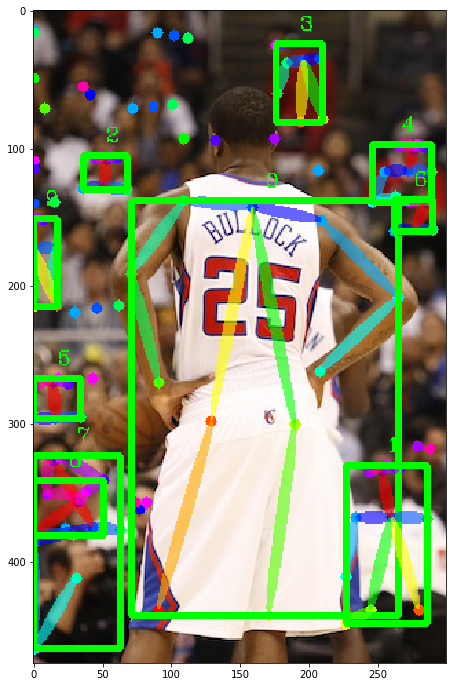

In [13]:
stickwidth = 4

# 關節及肢體顯示
for n in range(len(subset)):
    all_X=[]
    all_Y=[] 
    for i in range(17):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        #該人身上所有關節點的X,Y座標
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        #該人身上的所有關節點的X,Y座標最大, 最小, 平均值
        mX = np.mean(X)
        mY = np.mean(Y)
        all_Y.append(int(X[0]))
        all_Y.append(int(X[1]))
        all_X.append(int(Y[0]))
        all_X.append(int(Y[1]))

        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))

        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        # cv2.fillConvexPoly填充多邊形(給予凸點的位置即可)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        # cv2.addWeighted 兩張圖片疊加 (底圖, 底圖權重, 頂圖, 頂圖權重)
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    min_X = np.min(all_X)
    max_X = np.max(all_X)
    min_Y = np.min(all_Y)
    max_Y = np.max(all_Y)
    mean_X = int((min_X+max_X)/2)
    objectId = str(n)

    # cv2.rectangle畫框 (圖, 左上角座標, 右下角座標, 顏色BGR, 粗细)
    cv2.rectangle(canvas, (min_X,max_Y), (max_X,min_Y), (0,255,0), 4)
    # cv2.putText 標示文字 (圖, 文字, 位置, 字體, 大小, 顏色BGR, 粗细)
    cv2.putText(canvas,objectId,(mean_X,(min_Y-10)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1)

plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [14]:
detect_model = "model/digit-detector/detector_model.hdf5"
recognize_model = "model/digit-detector/recognize_model.hdf5"

mean_value_for_detector = 107.524
mean_value_for_recognizer = 112.833

model_input_shape = (32,32,1)
#DIR = '../datasets/svhn/train'

In [15]:
# 1. image files
#img_files = file_io.list_files(directory=DIR, pattern="*.png", recursive_option=False, n_files_to_sample=None, random_order=False)

preproc_for_detector = preproc.GrayImgPreprocessor(mean_value_for_detector)
preproc_for_recognizer = preproc.GrayImgPreprocessor(mean_value_for_recognizer)

char_detector = cls.CnnClassifier(detect_model, preproc_for_detector, model_input_shape)
char_recognizer = cls.CnnClassifier(recognize_model, preproc_for_recognizer, model_input_shape)

digit_spotter = detector.DigitSpotter(char_detector, char_recognizer, rp.MserRegionProposer())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 32,..., activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=N

Instructions for updating:
Use tf.cast instead.


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 32,..., activation="linear", kernel_size=(3, 3), filters=64, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=64, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=N

In [16]:
import pandas as pd
from sklearn.cluster import KMeans

df = pd.read_csv('C:/Users/shing/Desktop/player_info.csv', names =('Team','Num','Name','R','G','B'))  
RDB_med = df.groupby('Team').median()
R0_med, G0_med, B0_med = RDB_med.iloc[0,1:4]
R1_med, G1_med, B1_med = RDB_med.iloc[1,1:4]
print(RDB_med)

       Num      R      G      B
Team                           
A     25.0  244.0  233.0  231.0
B     13.0   27.5   48.5  156.5


In [46]:
oriImg = cv2.imread(test_image) 
canvas = oriImg
stickwidth = 4

# 關節及肢體顯示
for n in range(len(subset)):
    #把每個人的髖關節角度算出來
    angles = []
    for ls1, ls2, ls3 in [(1, 8, 9), (1, 11, 12)]:
        X1 = candidate[int(subset[n][ls1]), 0]
        Y1 = candidate[int(subset[n][ls1]), 1]
        X2 = candidate[int(subset[n][ls2]), 0]
        Y2 = candidate[int(subset[n][ls2]), 1]
        X3 = candidate[int(subset[n][ls3]), 0]
        Y3 = candidate[int(subset[n][ls3]), 1]

        points = np.array([[X1, Y1], [X2, Y2], [X3, Y3]])

        A = points[1] - points[0]
        B = points[2] - points[1]
        C = points[0] - points[2]

        #for e1, e2 in ((A, -B), (B, -C), (C, -A)):
        num = np.dot(A, -B)
        denom = np.linalg.norm(A) * np.linalg.norm(-B)
        angles.append(np.arccos(num/denom) * 180 / np.pi)
    
    # 如果此人兩個髖關節有一個角度>110 則判斷此人站著
    if any (a > 110 for a in angles):
        continue
    else:
        '''
        all_X=[]
        all_Y=[]                 
        for i in range(17):
            index = subset[n][np.array(limbSeq[i])-1]
            if -1 in index:
                continue
            
            cur_canvas = canvas.copy()
            #該人身上所有關節點的X,Y座標
            X = candidate[index.astype(int), 0]
            Y = candidate[index.astype(int), 1]
            #該人身上的所有關節點的X,Y座標最大, 最小, 平均值
            mX = np.mean(X)
            mY = np.mean(Y)
            all_X.append(int(X[0]))
            all_X.append(int(X[1]))
            all_Y.append(int(Y[0]))
            all_Y.append(int(Y[1]))

            
            length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))

            polygon = cv2.ellipse2Poly((int(mX),int(mY)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            # cv2.fillConvexPoly填充多邊形(給予凸點的位置即可)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            # cv2.addWeighted 兩張圖片疊加 (底圖, 底圖權重, 頂圖, 頂圖權重)
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
            '''
        # 設定背號會出現的位置
        X4 = int(candidate[int(subset[n][2]), 0])
        Y4 = int(candidate[int(subset[n][2]), 1])
        X5 = int(candidate[int(subset[n][5]), 0])
        Y5 = int(candidate[int(subset[n][5]), 1])

        sq_Ymin=min(Y4, Y5)
        sq_Xmin=min(X4, X5)
        sq_Xmax=max(X4, X5)
        z=int((sq_Xmax-sq_Xmin)/3)
        
        body_ori = oriImg[(sq_Ymin+z):(sq_Ymin+4*z), (sq_Xmin-z):(sq_Xmax+z)]   
        # 影像去噪
        body_img = np.array(cv2.fastNlMeansDenoisingColored(body_ori, None, 10, 10, 7, 21))
        result = digit_spotter.run(body_img, threshold=0.5, do_nms=True, show_result=False, nms_threshold=0.1)

        if np.issubdtype(type(result), int) is True:
            body_RGB = cv2.cvtColor(body_ori, cv2.COLOR_BGR2RGB)
            # reshape the image to be a list of pixels
            body_reshape = body_RGB.reshape((body_RGB.shape[0] * body_RGB.shape[1], 3))
            # cluster the pixel intensities
            clt = KMeans(n_clusters = 5)
            # reshape the image to be a list of pixels
            clt.fit(body_reshape)
            # 找出各色之比重
            hist = utils.centroid_histogram(clt)
            #找出顏色比重最重的hist index
            color_idx = np.where(hist==np.max(hist))
            #主色RDB為: clt.cluster_centers_[color_idx]
            color = clt.cluster_centers_[color_idx].flatten().tolist()
            #找出主色RDB與兩隊球衣主色之差異
            color_dif0 = abs(color[0]-R0_med)+abs(color[1]-G0_med)+abs(color[2]-B0_med)
            color_dif1 = abs(color[0]-R1_med)+abs(color[1]-G1_med)+abs(color[2]-B1_med)
            #差異小的即認定為該隊隊員
            if color_dif0 < color_dif1:
                team = RDB_med.index.values[0]
            else:
                team = RDB_med.index.values[1]
            
            msg = (team, result)
            print(msg)

            #min_X = np.min(all_X)
            #max_X = np.max(all_X)
            #min_Y = np.min(all_Y)
            #max_Y = np.max(all_Y)
            #mean_X = int((min_X+max_X)/2) 
            #objectId = str(n)
            
            # cv2.rectangle畫框 (圖, 左上角座標, 右下角座標, 顏色BGR, 粗细)
            cv2.rectangle(canvas, (sq_Xmin-z, sq_Ymin+z), (sq_Xmax+z, sq_Ymin+4*z), (0,255,0), 4)
            # cv2.putText 標示文字 (圖, 文字, 位置, 字體, 大小, 顏色BGR, 粗细)
            cv2.putText(canvas,str(msg),(sq_Xmin-z,(sq_Ymin+z-10)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1)
        
            
        else:
            continue
                        
            
        
        
cv2.imshow("Result", canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.


('A', 25)


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
